## 作業
在鐵達尼資料集中，今天我們專注觀察變數之間的相關性，以Titanic_train.csv 中，首先將有遺失值的數值刪除，並回答下列問題。
* Q1: 透過數值法計算  Age 和  Survived  是否有相關性?  
    * Age 和 Survived 呈現中度相關性
* Q2: 透過數值法計算  Sex 和 Survived  是否有相關性?
    * 
* Q3: 透過數值法計算  Age 和  Fare 是否有相關性?
    * 
* 提示:    
    1. 產生一個新的變數 Survived_cate，資料型態傳換成類別型態      
    2. 把題目中的 Survived 用 Survived_cate 來做分析       
    3. 首先觀察一下這些變數的資料型態後，再來想要以哪一種判斷倆倆的相關性。     

In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import math
import statistics
import seaborn as sns
from IPython.display import display

import pingouin as pg
import researchpy   
%matplotlib inline
import warnings; warnings.filterwarnings('ignore')

## 讀入資料

In [2]:
df_train = pd.read_csv("../data/Titanic_train.csv")
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [64]:
## 這邊我們做一個調整，把 Survived 變成離散型變數 Survived_cate
df = df_train.copy()
df['Survived_cat'] = df['Survived'].apply(lambda x: 'Y' if x == 1 else 'N')

In [65]:
df.isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Survived_cat      0
dtype: int64

---
###  Q1: 透過數值法計算  Age 和  Survived  是否有相關性?

In [68]:
complete_df = df[['Age', 'Survived']].dropna()  # 只要刪除特定空值即可
complete_df

,Age,Survived
0,22.0,0
1,38.0,1
2,26.0,1
3,35.0,1
4,35.0,0
...,...,...
885,39.0,0
886,27.0,0
887,19.0,1
889,26.0,1


In [78]:
# 連續．離散
# 使用 Eta Square
#   dv: Name of column in data containing the dependent variable.
#   between: Name of column(s) in data containing the between-subject factor(s).
#   'SS'(return): Sums of squares
aov = pg.anova(dv='Age', between='Survived_cat', data=df, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Survived_cat,897.187582,1,897.187582,4.271195,0.039125,0.005963
1,Within,149559.448362,712,210.055405,NaN,NaN,NaN


In [70]:
etaSq = aov.SS[0] / (aov.SS[0] + aov.SS[1])
etaSq

0.0059630974469252

In [71]:
def judgment_etaSq(etaSq):
    if etaSq < .01:
        qual = 'Negligible'
    elif etaSq < .06:
        qual = 'Small'
    elif etaSq < .14:
        qual = 'Medium'
    else:
        qual = 'Large'
    return(qual)

judgment_etaSq(etaSq)

'Negligible'

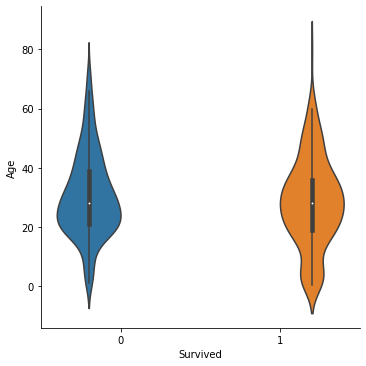

In [74]:
g = sns.catplot(
    x="Survived",
    y="Age", 
    hue="Survived",
    data=complete_df, 
    kind="violin"
)

* Age 和 Survived 無相關性

---
### Q2: 透過數值法計算  Sex 和 Survived  是否有相關性?

In [76]:
# 離散．離散
# 使用 Cramér's V

cross_table = pd.crosstab(df['Sex'], df['Survived_cat'])
display(cross_table)

Survived_cat,N,Y
Sex,,
female,81,233
male,468,109


In [44]:
cross_table.shape

(2, 2)

In [43]:
# 計算自由度（自由度範例：三角形三個角度，只要決定了 2 個角，則第三個角度也會決定＝自由度只有 2）
df_ = min(cross_table.shape[0], cross_table.shape[1]) - 1  # min(2, 2)-1
df_

1

In [79]:
crosstab, result = researchpy.crosstab(df['Sex'], df['Survived_cat'], test='chi-square')
crosstab

Survived_cat          
Survived_cat            N    Y  All
Sex                                
female                 81  233  314
male                  468  109  577
All                   549  342  891

In [80]:
result   
# Cramer's Phi = 2x2 table
# Cramer's V   = larger than 2x2

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,263.0506
1,p-value =,0.0000
2,Cramer's phi =,0.5434


In [82]:
## 寫一個副程式判斷相關性的強度
def judgment_CramerV(df, V):
    if df == 1:
        if V < 0.10:
            qual = 'negligible'
        elif V < 0.30:
            qual = 'small'
        elif V < 0.50:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 2:
        if V < 0.07:
            qual = 'negligible'
        elif V < 0.21:
            qual = 'small'
        elif V < 0.35:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 3:
        if V < 0.06:
            qual = 'negligible'
        elif V < 0.17:
            qual = 'small'
        elif V < 0.29:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 4:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.15:
            qual = 'small'
        elif V < 0.25:
            qual = 'medium'
        else:
            qual = 'large'
    else:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.13:
            qual = 'small'
        elif V < 0.22:
            qual = 'medium'
        else:
            qual = 'large'
    return(qual)

judgment_CramerV(df_, result.loc[2, 'results'])

'large'

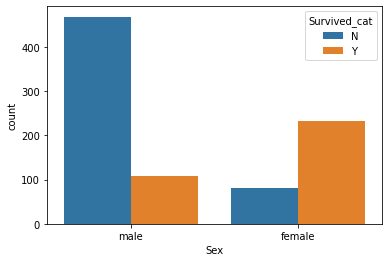

In [83]:
g = sns.countplot(x="Sex", hue="Survived_cat", data=df)

* Sex 和 Survived 呈現高度相關性 （自由度 = 1, Cramer's phi = 0.5434）

---
### Q3: 透過數值法計算  Age 和  Fare 是否有相關性?  

In [87]:
complete_df = df[['Age', 'Fare']].dropna()

In [88]:
# 連續．連續
# 使用 Pearson 相關係數
corr, _ = stats.pearsonr(complete_df['Age'], complete_df['Fare'])
corr

0.0960666917690389

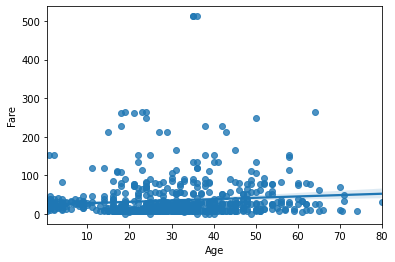

In [89]:
g = sns.regplot('Age', 'Fare', data=df)

* Age 和 Fare 無線性相關 (Pearson 相關係數 = 0.09 < 0.1)

---
## Q1: 透過數值法計算  Age 和  Survived  是否有相關性?  
* 連續．離散 = 使用 Eta Square
* Age 和 Survived 無相關性（etaSqu = 0.0059）
    
    
## Q2: 透過數值法計算  Sex 和 Survived  是否有相關性?
* 離散．離散 = 使用 Cramér's V
* Sex 和 Survived 呈現高度相關性 （自由度 = 1, Cramer's phi = 0.5434)
    
## Q3: 透過數值法計算  Age 和  Fare 是否有相關性?
* 連續．連續 = 使用 Pearson 相關係數
* Age 和 Fare 無線性相關 (Pearson 相關係數 = 0.09 < 0.1)